In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

data = pd.read_csv("/gdrive/My Drive/yelp.csv", usecols=['text', 'stars'])



Mounted at /gdrive


In [21]:
#M class has way less data than the orthers, thus the classes are unbalanced.
data.stars.value_counts()
data['stars'] = data['stars'].apply(str)
data.dtypes

text     object
stars    object
dtype: object

In [0]:
#I do aspire here to have balanced classes
num_of_categories = 58000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['stars'] == '1'][:num_of_categories]
b = shuffled[shuffled['stars'] == '2'][:num_of_categories]
t = shuffled[shuffled['stars'] == '3'][:num_of_categories]
m = shuffled[shuffled['stars'] == '4'][:num_of_categories]
f = shuffled[shuffled['stars'] == '5'][:num_of_categories]
concated = pd.concat([e,b,t,m,f], ignore_index=True)
concated
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [23]:
#One-hot encode the lab
concated.loc[concated['stars'] == '1', 'LABEL'] = 0
concated.loc[concated['stars'] == '2', 'LABEL'] = 1
concated.loc[concated['stars'] == '3', 'LABEL'] = 2
concated.loc[concated['stars'] == '4', 'LABEL'] = 3
concated.loc[concated['stars'] == '5', 'LABEL'] = 4
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=5)
print(labels[:10])
if 'stars' in concated.keys():
    concated.drop(['stars'], axis=1)

42100     0
112613    1
216747    3
65923     1
81130     1
10089     0
279160    4
41826     0
5902      0
24559     0
Name: LABEL, dtype: int64
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [25]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['text'].values)
sequences = tokenizer.texts_to_sequences(concated['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 194351 unique tokens.


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [27]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [29]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((217500, 130), (217500, 5), (72500, 130), (72500, 5))
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 1,073,733
Trainable params: 1,073,733
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 174000 samples, validate on 43500 samples
Epoch 1/10





174000/174000 [===

In [30]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

72500/72500 [==============================] - 236s 3ms/step
Test set
  Loss: 0.917
  Accuracy: 0.602


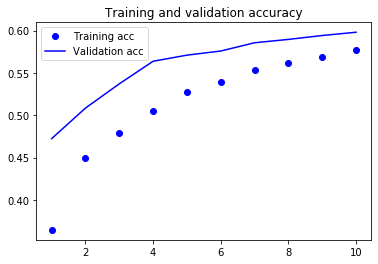

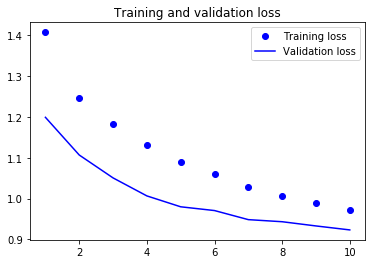

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['1', '2', '3', '4', '5']
#print(pred, labels[np.argmax(pred)])
#print(np.argmax(pred))

print("====result=====")
rating = np.argmax(pred)
if rating == 0 :
  print(labels[0])
elif rating == 1:
  print(labels[1])
elif rating == 2:
  print(labels[2])
elif rating == 3:
  print(labels[3])
elif rating == 4:
  print(labels[4])


====result=====
4
